In [64]:
import optuna
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [57]:
marketing_df = pd.read_csv('../3. data_after_txt_proc/bank_marketing_data_after_txt_proc.csv')
personal_df = pd.read_csv('../3. data_after_txt_proc/Bank_Personal_Loan_Modelling_after_txt_proc.csv')

# marketing_df

In [58]:
X_m, y_m = marketing_df.drop(columns='deposit'), marketing_df.deposit

In [59]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.2, random_state=42)

In [60]:
def objective_m(trial):
    # Гиперпараметры для оптимизации
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])

    # Ограничение выбора solver для 'elasticnet'
    if penalty == 'elasticnet':
        solver = 'saga'
    else:
        solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])

    # Параметр l1_ratio для ElasticNet
    l1_ratio = None
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)

    # Создание пайплайна
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            l1_ratio=l1_ratio if penalty == 'elasticnet' else None,
            max_iter=5000,
            random_state=42
        ))
    ])

    # Кросс-валидация
    score = cross_val_score(model, X_train_m, y_train_m, cv=5, scoring='accuracy').mean()
    return score

In [61]:
%%time
study_m = optuna.create_study(direction='maximize')
study_m.optimize(objective_m, n_trials=50)

[I 2024-12-04 15:43:42,766] A new study created in memory with name: no-name-44131cbf-6f76-4f41-a602-867f511d21bf
C:\Users\mitay\AppData\Local\Temp\ipykernel_8268\120367745.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
[I 2024-12-04 15:43:42,910] Trial 0 finished with value: 0.8035620339961292 and parameters: {'C': 0.004890896182507531, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.8035620339961292.
C:\Users\mitay\AppData\Local\Temp\ipykernel_8268\120367745.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
[I 2024-12-04 15:43:43,056] Trial 1 finishe

CPU times: total: 30.8 s
Wall time: 31.1 s


In [66]:
print("Best hyperparameters:", study_m.best_params)
print("Best cross-validation score:", study_m.best_value)

Best hyperparameters: {'C': 40.22545705496953, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.8079297116382949


In [67]:
best_model_m = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        C=study_m.best_params['C'],
        penalty=study_m.best_params['penalty'],
        solver=study_m.best_params['solver'],
        l1_ratio=study_m.best_params.get('l1_ratio', None),  # Проверяем наличие l1_ratio
        max_iter=1000,
        random_state=42
    ))
])

In [68]:
best_model_m.fit(X_train_m, y_train_m)


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=40.22545705496953, max_iter=1000,
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [69]:
# Оценка модели на тестовых данных для marketing_df
y_pred_m = best_model_m.predict(X_test_m)
y_pred_proba_m = best_model_m.predict_proba(X_test_m)[:, 1]

# Метрики
test_accuracy_m = accuracy_score(y_test_m, y_pred_m)
test_f1_m = f1_score(y_test_m, y_pred_m)
test_precision_m = precision_score(y_test_m, y_pred_m)
test_recall_m = recall_score(y_test_m, y_pred_m)
test_roc_auc_m = roc_auc_score(y_test_m, y_pred_proba_m)

# Вывод метрик
print(f"\nMetrics for marketing_df:")
print(f"Accuracy: {test_accuracy_m:.4f}")
print(f"F1 Score: {test_f1_m:.4f}")
print(f"Precision: {test_precision_m:.4f}")
print(f"Recall: {test_recall_m:.4f}")
print(f"ROC-AUC: {test_roc_auc_m:.4f}")


Metrics for marketing_df:
Accuracy: 0.7980
F1 Score: 0.7816
Precision: 0.8086
Recall: 0.7563
ROC-AUC: 0.8862


Feature importance (sorted):
duration: 1.8283
contact_cellular: 0.5762
poutcome_success: 0.5079
housing: 0.4095
poutcome_unknown: 0.3779
contact_telephone: 0.3190
campaign: 0.3039
education_tertiary: 0.2137
loan: 0.2063
poutcome_failure: 0.1496
job_retired: 0.1391
job_student: 0.1178
marital_single: 0.1026
balance: 0.0839
poutcome_other: 0.0836
job_blue-collar: 0.0820
job_entrepreneur: 0.0675
job_self-employed: 0.0666
month: 0.0663
job_admin.: 0.0650
marital_divorced: 0.0639
education_secondary: 0.0636
job_management: 0.0603
job_services: 0.0498
day: 0.0475
education_primary: 0.0435
education_unknown: 0.0390
previous: 0.0357
job_housemaid: 0.0308
job_unemployed: 0.0271
age: 0.0241
default: 0.0237
job_technician: 0.0138
job_unknown: 0.0127
marital_married: 0.0100
contact_unknown: 0.0087
pdays: 0.0015


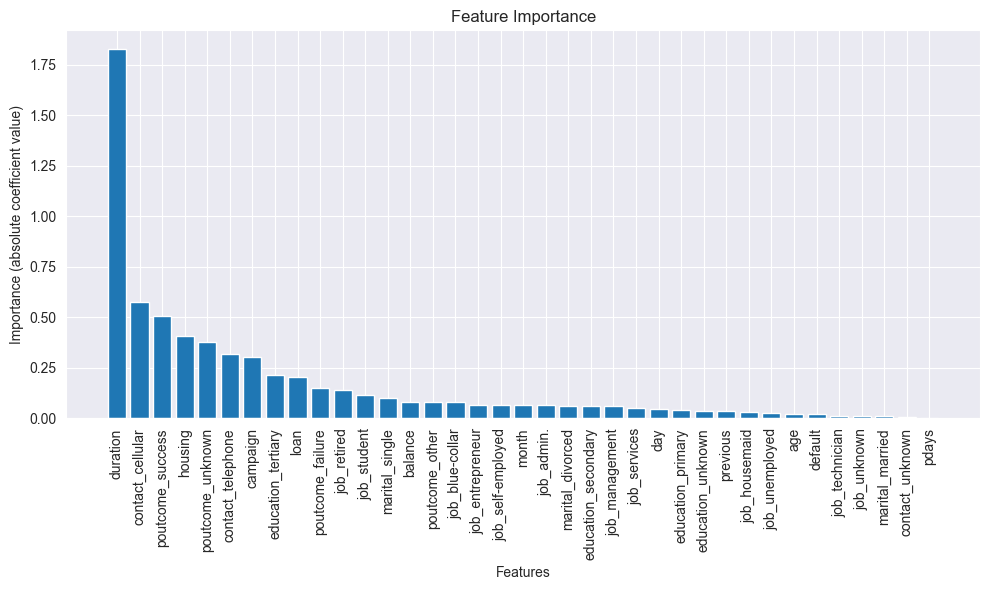

In [70]:
import numpy as np
import matplotlib.pyplot as plt

feature_names_m = [i for i in X_m.columns]  # Для make_classification

# Оценка модели с оптимизированными гиперпараметрами
best_model_m.fit(X_train_m, y_train_m)

# Извлечение коэффициентов модели
clf_m = best_model_m.named_steps['clf']
if hasattr(clf_m, 'coef_'):
    feature_importances_m = np.abs(clf_m.coef_[0])  # Для бинарной классификации
    feature_indices_m = np.argsort(feature_importances_m)[::-1]

    # Вывод важности признаков
    print("Feature importance (sorted):")
    for idx in feature_indices_m:
        print(f"{feature_names_m[idx]}: {feature_importances_m[idx]:.4f}")

    # Визуализация важности признаков
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances_m)), feature_importances_m[feature_indices_m])
    plt.xticks(range(len(feature_importances_m)), [feature_names_m[i] for i in feature_indices_m], rotation=90)
    plt.title("Feature Importance")
    plt.xlabel("Features")
    plt.ylabel("Importance (absolute coefficient value)")
    plt.tight_layout()
    plt.show()
else:
    print("Model does not provide feature coefficients.")


# Personal_df

In [71]:
X_p, y_p = personal_df.drop(columns='Personal Loan'), personal_df['Personal Loan']

In [72]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p, test_size=0.2, random_state=42)


In [73]:
def objective_p(trial):
    # Гиперпараметры для оптимизации
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])

    # Ограничение выбора solver для 'elasticnet'
    if penalty == 'elasticnet':
        solver = 'saga'
    else:
        solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])

    # Параметр l1_ratio для ElasticNet
    l1_ratio = None
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)

    # Создание пайплайна
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            l1_ratio=l1_ratio if penalty == 'elasticnet' else None,
            max_iter=5000,
            random_state=42
        ))
    ])

    # Кросс-валидация
    score = cross_val_score(model, X_train_p, y_train_p, cv=5, scoring='accuracy').mean()
    return score

In [74]:
%%time
study_p = optuna.create_study(direction='maximize')
study_p.optimize(objective_p, n_trials=50)

[I 2024-12-04 15:45:00,491] A new study created in memory with name: no-name-0dd21de8-0a34-4c53-ab00-bf1981a44463
C:\Users\mitay\AppData\Local\Temp\ipykernel_8268\3461054765.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
[I 2024-12-04 15:45:00,551] Trial 0 finished with value: 0.9504999999999999 and parameters: {'C': 0.23610032611483278, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.9504999999999999.
C:\Users\mitay\AppData\Local\Temp\ipykernel_8268\3461054765.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
[I 2024-12-04 15:45:00,632] Trial 1 finish

CPU times: total: 14 s
Wall time: 14.6 s


In [75]:
print("Best hyperparameters:", study_p.best_params)
print("Best cross-validation score:", study_p.best_value)

Best hyperparameters: {'C': 0.5095973412011809, 'penalty': 'elasticnet', 'l1_ratio': 0.4748399673343778}
Best cross-validation score: 0.95175


In [76]:
best_model_p = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        C=study_m.best_params['C'],
        penalty=study_m.best_params['penalty'],
        solver=study_m.best_params['solver'],
        l1_ratio=study_m.best_params.get('l1_ratio', None),  # Проверяем наличие l1_ratio
        max_iter=5000,
        random_state=42
    ))
])

In [77]:
best_model_p.fit(X_train_p, y_train_p)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=40.22545705496953, max_iter=5000,
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [78]:
y_pred_p = best_model_p.predict(X_test_p)
y_pred_proba_p = best_model_p.predict_proba(X_test_p)[:, 1]

# Метрики
test_accuracy_p = accuracy_score(y_test_p, y_pred_p)
test_f1_p = f1_score(y_test_p, y_pred_p)
test_precision_p = precision_score(y_test_p, y_pred_p)
test_recall_p = recall_score(y_test_p, y_pred_p)
test_roc_auc_p = roc_auc_score(y_test_p, y_pred_proba_p)

# Вывод метрик
print(f"Metrics for personal_df:")
print(f"Accuracy: {test_accuracy_p:.4f}")
print(f"F1 Score: {test_f1_p:.4f}")
print(f"Precision: {test_precision_p:.4f}")
print(f"Recall: {test_recall_p:.4f}")
print(f"ROC-AUC: {test_roc_auc_p:.4f}")

Metrics for personal_df:
Accuracy: 0.9540
F1 Score: 0.7553
Precision: 0.8554
Recall: 0.6762
ROC-AUC: 0.9676


Feature importance (sorted):
Income: 2.4496
Education: 1.3796
CD Account: 0.9133
Family: 0.8365
Experience: 0.7726
Age: 0.6475
CreditCard: 0.5707
Online: 0.3103
Securities Account: 0.2780
CCAvg: 0.1847
ZIP Code: 0.0911
Mortgage: 0.0552


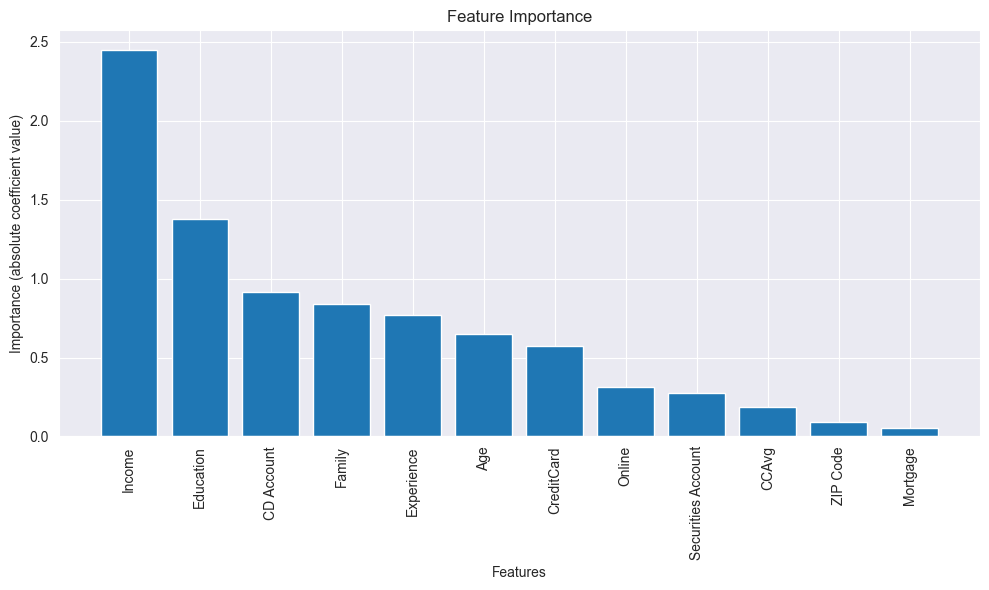

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Названия признаков
feature_names_p = [i for i in X_p.columns]  # Для make_classification

# Оценка модели с оптимизированными гиперпараметрами
best_model_p.fit(X_train_p, y_train_p)

# Извлечение коэффициентов модели
clf_p = best_model_p.named_steps['clf']
if hasattr(clf_p, 'coef_'):
    feature_importances_p = np.abs(clf_p.coef_[0])  # Для бинарной классификации
    feature_indices_p = np.argsort(feature_importances_p)[::-1]

    # Вывод важности признаков
    print("Feature importance (sorted):")
    for idx in feature_indices_p:
        print(f"{feature_names_p[idx]}: {feature_importances_p[idx]:.4f}")

    # Визуализация важности признаков
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances_p)), feature_importances_p[feature_indices_p])
    plt.xticks(range(len(feature_importances_p)), [feature_names_p[i] for i in feature_indices_p], rotation=90)
    plt.title("Feature Importance")
    plt.xlabel("Features")
    plt.ylabel("Importance (absolute coefficient value)")
    plt.tight_layout()
    plt.show()
else:
    print("Model does not provide feature coefficients.")
